In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns; sns.set(style="white", font_scale=2)

import numpy as np
import pandas as pd
from astropy.io import fits
import glob

import sklearn
import sklearn.metrics

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import random_channel_shift
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')

import scipy.ndimage as ndi

import matplotlib.patches as patches
import pathlib


Using TensorFlow backend.


In [2]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = np.array((10,6))
mpl.rcParams['figure.facecolor'] = "white"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

# To Do
 1. Read in fits images
 2. Apply pre-processing stretch (asinh)
 3. crop image smaller
 4. Combine filters into one cube
 5. Create training set with labels
 6. Set up keras model
 7. Poke around at the results
 
 

# 0) Get files

In [5]:
images_dir = "../data/galaxy_images_training/quarry_files/"

In [6]:
HSC_ids = [int(os.path.basename(image_file).split("-")[0])
           for image_file in glob.glob(os.path.join(images_dir, "*.fits"))]
HSC_ids = set(HSC_ids) # remove duplicates
HSC_ids = np.array(sorted(HSC_ids))

# now filter out galaxies missing bands
HSC_ids = [HSC_id
           for HSC_id in HSC_ids
           if len(glob.glob(os.path.join(images_dir, "{}*.fits".format(str(HSC_id)))))==5]
HSC_ids = np.array(HSC_ids)

In [7]:
HSC_ids.size

1866

In [8]:
HSC_id = HSC_ids[2] # for when I need a single sample galaxy

In [9]:
bands = ["g", "r", "i", "z", "y"]

# 1) Read in fits image


In [10]:
import preprocessing

In [11]:
image, flux_mag_0 = preprocessing.get_image(HSC_id, "g")
print("image size: {} x {}".format(*image.shape))
image

image size: 239 x 239


array([[-5.1946715e-02,  5.2224647e-02,  1.2836658e-02, ...,
        -4.2683050e-02,  4.6599112e-02, -9.3426881e-03],
       [-2.4148472e-02,  4.9130496e-02, -1.0081916e-05, ...,
         4.0721711e-02,  1.4573295e-02, -4.0571071e-02],
       [-6.8525448e-03,  5.2679256e-03, -6.4173182e-03, ...,
         3.4137823e-02, -7.7981845e-02, -2.1136018e-02],
       ...,
       [-8.8869138e-03,  3.1337745e-02,  8.5042417e-04, ...,
         3.2482971e-02, -2.9819449e-02,  4.8630014e-03],
       [ 5.8512330e-02,  4.9714420e-02,  8.1128389e-02, ...,
        -2.5828091e-02,  3.4173269e-02, -4.4498667e-02],
       [ 1.3712918e-02, -2.2365674e-02,  3.0620810e-02, ...,
         2.5152223e-02, -1.5306322e-02, -4.1226905e-02]], dtype=float32)

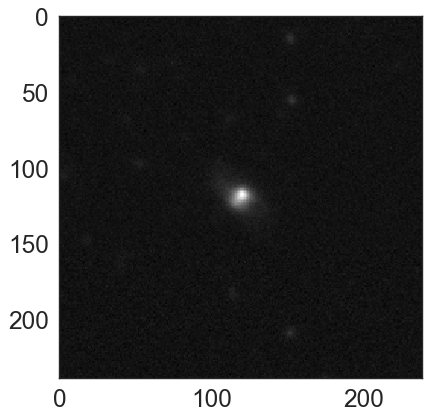

In [12]:
preprocessing.image_plotter(image)

/Users/egentry/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


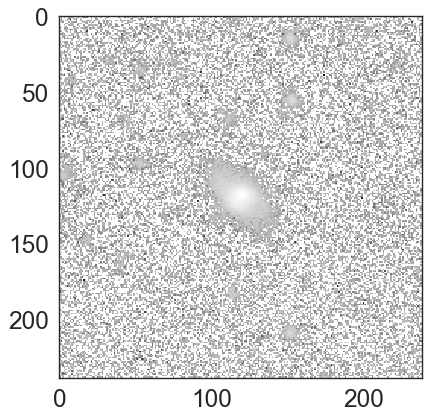

In [13]:
preprocessing.image_plotter(np.log(image))

# 2) Apply stretch

We're using (negative) asinh magnitudes, as implemented by the HSC collaboration.

To see more about asinh magnitude system, see : [Lupton, Gunn and Szalay (1999)](http://iopscience.iop.org/article/10.1086/301004/meta) used for SDSS. (It's expliticly given in the [SDSS Algorithms](http://classic.sdss.org/dr7/algorithms/fluxcal.html) documentation as well as [this overview page](https://ned.ipac.caltech.edu/help/sdss/dr6/photometry.html#asinh)).

To see the source of our code, see: [the HSC color image creator](https://hsc-gitlab.mtk.nao.ac.jp/snippets/23#L172)

And for reference, a common form of this stretch is:
$$ \mathrm{mag}_\mathrm{asinh} = - \left(\frac{2.5}{\ln(10)}\right) \left(\mathrm{asinh}\left(\frac{f/f_0}{2b}\right) + \ln(b) \right)$$
for dimensionless softening parameter $b$, and reference flux (f_0).


In [14]:
image_scaled = preprocessing.scale(image, flux_mag_0)

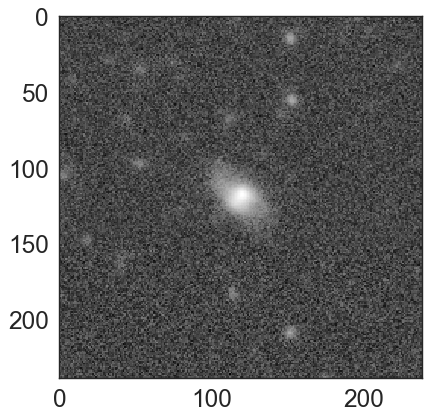

In [15]:
preprocessing.image_plotter(image_scaled)

Text(0.5, 1.0, 'Distribution of Transformed Intensities')

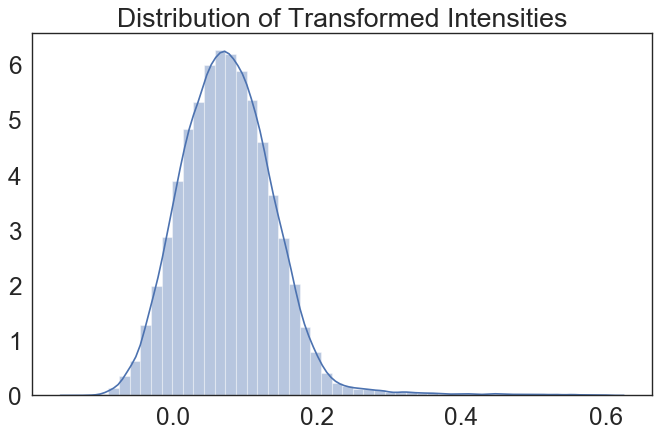

In [16]:
sns.distplot(image_scaled.flatten())
plt.title("Distribution of Transformed Intensities")

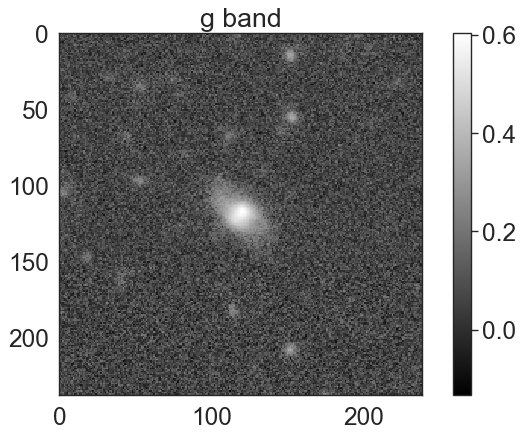

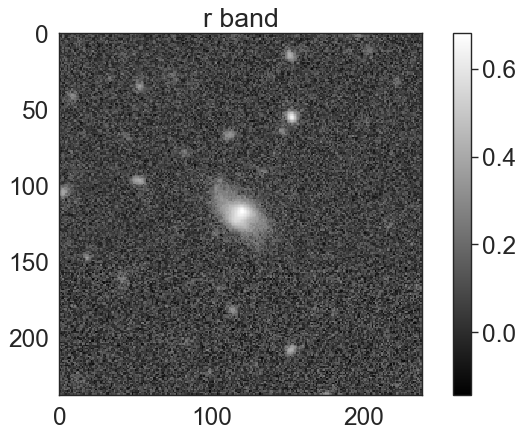

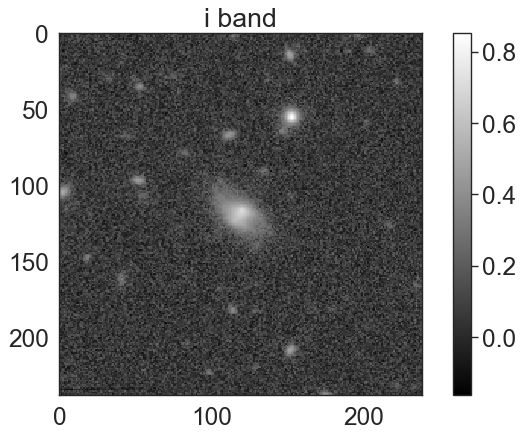

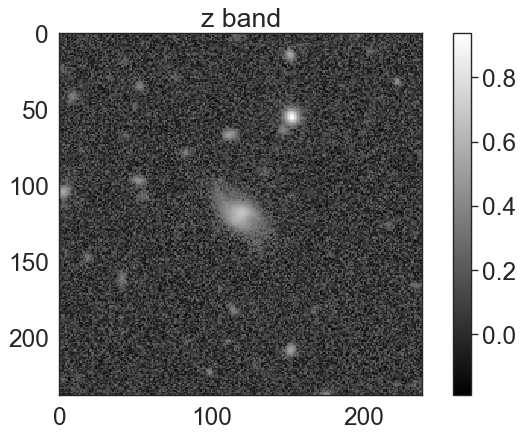

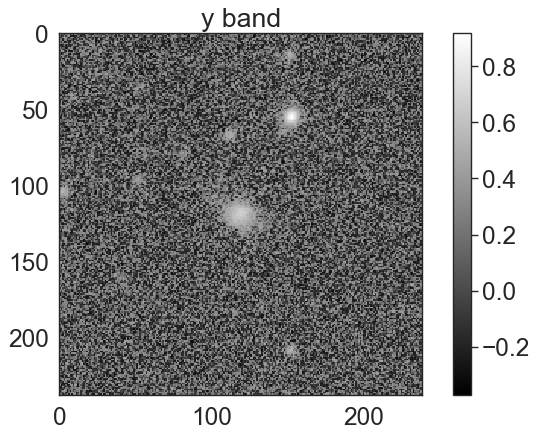

In [17]:
for band in bands:
    image, flux_mag_0 = preprocessing.get_image(HSC_id, band)
    image_scaled = preprocessing.scale(image, flux_mag_0)

    plt.figure()
    preprocessing.image_plotter(image_scaled)
    plt.title("{} band".format(band))
    plt.colorbar()


# 3) Crop Image
Am I properly handling odd numbers?

In [18]:
pre_transformed_image_size  = 150
post_transformed_image_size = 75

In [19]:
cutout = preprocessing.get_cutout(image_scaled, post_transformed_image_size)
cutout.shape

(75, 75)

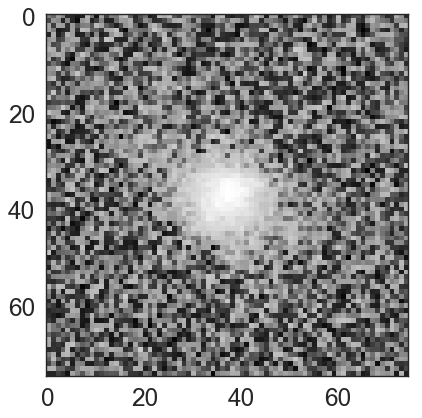

In [20]:
preprocessing.image_plotter(cutout)

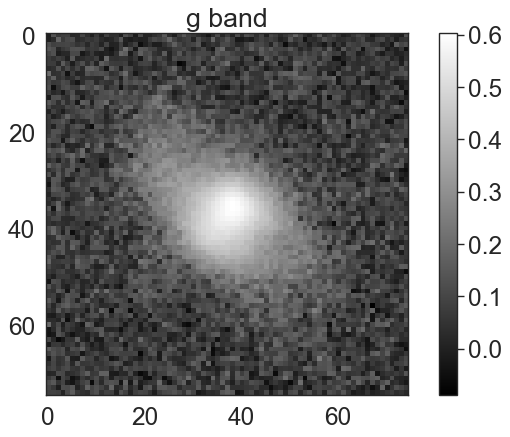

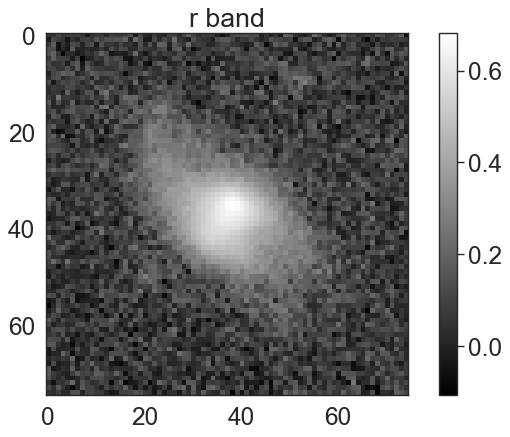

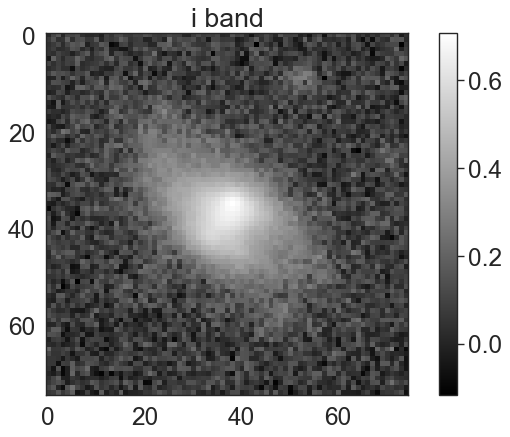

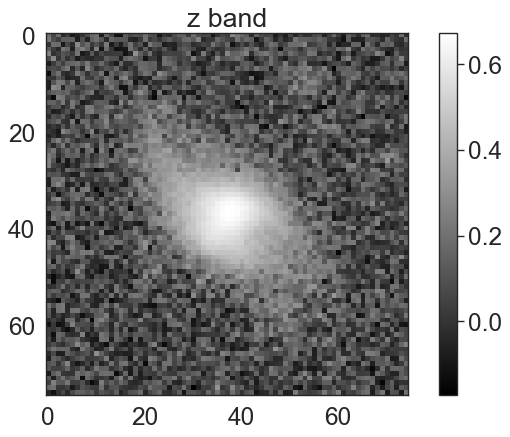

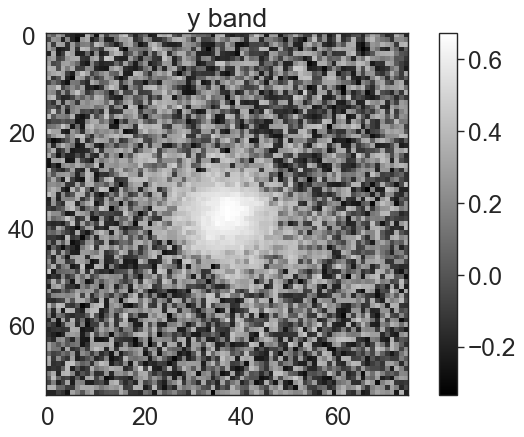

In [21]:
for band in bands:
    image, flux_mag_0 = preprocessing.get_image(HSC_id, band)
    image_scaled = preprocessing.scale(image, flux_mag_0)
    cutout = preprocessing.get_cutout(image_scaled, post_transformed_image_size)

    plt.figure()
    preprocessing.image_plotter(cutout)
    plt.title("{} band".format(band))
    plt.colorbar()

# 4) Combine filters into cube

In [22]:
images = [None]*len(bands)
flux_mag_0s = [None]*len(bands)
cutouts = [None]*len(bands)
for i, band in enumerate(bands):
    images[i], flux_mag_0s[i] = preprocessing.get_image(HSC_id, band)
    
    cutouts[i] = preprocessing.get_cutout(
        preprocessing.scale(images[i], flux_mag_0s[i]), 
        post_transformed_image_size
    )


In [23]:
cutout_cube = np.array(cutouts)
cutout_cube.shape

(5, 75, 75)

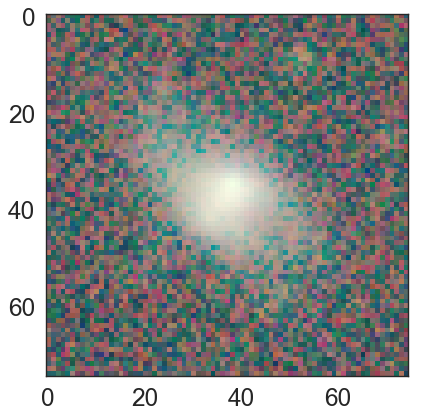

In [24]:
# must transform into [0,1] for plt.imshow
# the HSC standard tool accomplishes this by clipping instead.
plt.imshow(preprocessing.transform_0_1(cutout_cube[(4,2,0),:,:].transpose(1,2,0)) )

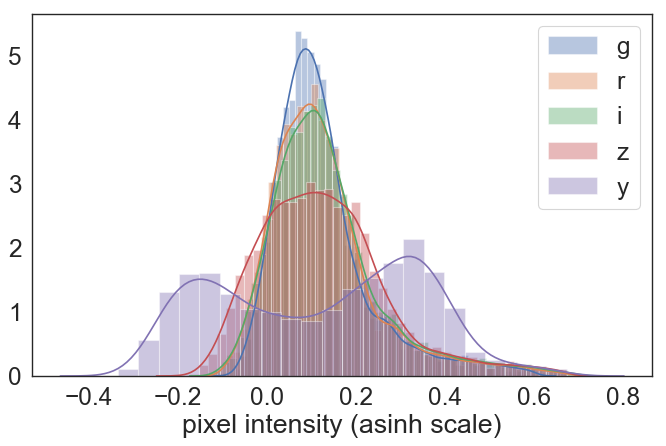

In [25]:
for i, band in enumerate(bands):
    sns.distplot(cutout_cube[:,:,:].transpose(1,2,0)[:,:,i].flatten(), label=band)
    plt.legend(loc="best")
    plt.xlabel("pixel intensity (asinh scale)")

# 5) Load Training Set Labels

In [26]:
training_set_labels_filename = "../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv"

In [27]:
df = pd.read_csv(training_set_labels_filename)
df = df.drop_duplicates("HSC_id")
df = df.set_index("HSC_id")
df = df[["low_z_low_mass"]]
df = df.rename(columns={"low_z_low_mass":"target"})
df.head()

,target
HSC_id,
43158322471244656,False
43158605939114836,False
43159142810013665,False
43158734788125011,False
43158863637144621,True


In [28]:
def load_image_mappable(HSC_id):
    images      = [None]*len(bands)
    flux_mag_0s = [None]*len(bands)
    cutouts     = [None]*len(bands)
    for j, band in enumerate(bands):
        images[j], flux_mag_0s[j] = preprocessing.get_image(HSC_id, band)
        cutouts[j] = preprocessing.get_cutout(
            preprocessing.scale(images[j], flux_mag_0s[j]),
            pre_transformed_image_size
        )
    cutout_cube = np.array(cutouts)
    return cutout_cube


In [29]:
X = np.empty((len(HSC_ids), 5, 
              pre_transformed_image_size, pre_transformed_image_size))

In [30]:
X = np.array(list(map(load_image_mappable, HSC_ids)))

In [31]:
X_full = X
X_small = X[:,(0,2,4),:,:] # drop down to 3 bands

In [32]:
X.shape

(1866, 5, 150, 150)

In [33]:
Y = df.loc[HSC_ids].target.values
Y

array([False, False,  True, ..., False, False, False])

In [34]:
Y.mean()

0.2792068595927117

# Geometric Transformations for Data Augmentation

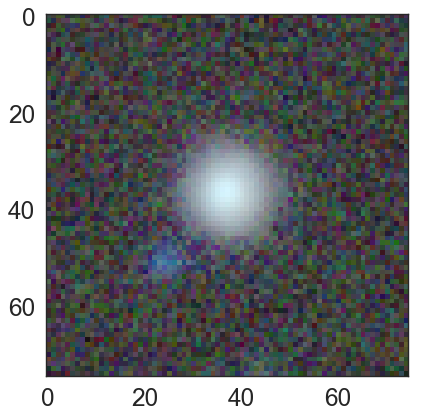

In [35]:
import geometry

h = pre_transformed_image_size
w = pre_transformed_image_size
transform_matrix = geometry.create_random_transform_matrix(h, w,
                                                  include_rotation=True,
                                                  translation_size = .01,
                                                  verbose=False)

x_tmp = X[0][:3]

result = geometry.apply_transform_new(x_tmp, transform_matrix, 
                            channel_axis=0, fill_mode="constant", cval=np.max(x_tmp))

result = preprocessing.get_cutout(x_tmp, post_transformed_image_size)
plt.imshow(preprocessing.transform_0_1(result.transpose(1,2,0)))

In [36]:
import ipywidgets
ipywidgets.interact(preprocessing.transform_plotter,
                    X = ipywidgets.fixed(X),
                    rotation_degrees = ipywidgets.IntSlider(min=0, max=360, step=15, value=45),
                    dx_after = ipywidgets.IntSlider(min=-15, max=15),
                    dy_after = ipywidgets.IntSlider(min=-15, max=15),
                    color = ipywidgets.fixed(True),
                    shear_degrees = ipywidgets.IntSlider(min=0, max=90, step=5, value=0),
                    zoom_x = ipywidgets.FloatSlider(min=.5, max=2, value=1),
                    crop = ipywidgets.Checkbox(value=True)
                    )

interactive(children=(Checkbox(value=False, description='reflect_x'), IntSlider(value=45, description='rotatio…

<function preprocessing.transform_plotter(X, reflect_x=False, rotation_degrees=45, dx_after=0, dy_after=0, shear_degrees=0, zoom_x=1, crop=False, color=True)>

## 5b) Split training and testing set

In [37]:
randomized_indices = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
testing_set_indices = randomized_indices[:int(testing_fraction*X.shape[0])]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [38]:
print(training_set_indices.size)
print(Y[training_set_indices].mean())

1493
0.27461486939048896


In [39]:
print(testing_set_indices.size)
print(Y[testing_set_indices].mean())

373
0.2975871313672922


In [40]:
p = Y[training_set_indices].mean()
prior_loss = sklearn.metrics.log_loss(Y[testing_set_indices], 
                                      [p]*testing_set_indices.size)

prior_loss

0.6101087775907272

## 6b) Adapt NumpyArrayIterator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images.

Also, I want to change the way that augmentation is happening

In [41]:
from data_generator import ArrayIterator

## 6c) Adapt ImageDataGenerator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images. Also, I'm adjusting the way that the affine transformations work for the data augmentation

In [42]:
from data_generator import ImageDataGenerator

## 6d) Create Data Generator

In [43]:
print('Using real-time data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

h_after = post_transformed_image_size
w_after = post_transformed_image_size
print("image shape after:  ({},{})".format(h_after, w_after))

# get a closure that binds the image size to get_cutout
postprocessing_function = lambda image: preprocessing.get_cutout(image, post_transformed_image_size)

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    with_reflection_x=True, # randomly apply a reflection (in x)
    with_reflection_y=True, # randomly apply a reflection (in y)
    with_rotation=False, # randomly apply a rotation
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
    postprocessing_function=postprocessing_function, # get a cutout of the processed image
    output_image_shape=(post_transformed_image_size,post_transformed_image_size)
)   

Using real-time data augmentation.
image shape before: (150,150)
image shape after:  (75,75)


In [44]:
datagen.fit(X[training_set_indices])

# 7) Set up `keras` model

In [45]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = cutout_cube.shape

dropout_fraction = .50

nb_dense = 64

In [46]:
model = Sequential()

model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))


model.add(Conv2D(n_conv_filters, conv_kernel_size*2,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Conv2D(n_conv_filters, conv_kernel_size*4,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 75, 75)        1296      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 75, 75)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 37, 37)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 37, 37)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 37, 37)        16400     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 37, 37)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 18, 18)        0         
__________

In [48]:
learning_rate = 0.00025
decay = 1e-5
momentum = 0.9

# sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [49]:
logger_filename = "training.log"

model.compile(loss='binary_crossentropy', 
#               optimizer=sgd, 
              optimizer=adam,
#               metrics=["accuracy"]
             )

if os.path.exists(logger_filename):
    logger_filename_tmp = logger_filename + ".old"
    os.rename(logger_filename, logger_filename_tmp)


In [50]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


In [51]:
csv_logger = keras.callbacks.CSVLogger(logger_filename,
                                       append=True)

In [52]:
# modelcheckpoint = ModelCheckpoint(pathinCat+'Models/bestmodelMAG.hdf5',monitor='val_loss',verbose=0,save_best_only=True)


# 8) Run basic keras model

In [53]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epoch_to_save_state = 100
epochs = 400
verbose = 1

steps_per_epoch:  23
batch_size:  64


In [54]:
X_test_transformed = np.array([datagen.standardize(X_img)
                               for X_img in X[testing_set_indices]])

X_test_transformed.shape

(373, 5, 75, 75)

In [55]:
prior_loss

0.6101087775907272

In [56]:
args = (datagen.flow(X[training_set_indices], 
                                           Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
       )

kwargs = dict(steps_per_epoch=steps_per_epoch,
              validation_data=(X_test_transformed, 
                               Y[testing_set_indices]),
              verbose=verbose,
              callbacks=[csv_logger],
             )

history = model.fit_generator(*args,
                              epochs=epoch_to_save_state,
                              **kwargs,
                              )  

print("saving state after {} epochs".format(epoch_to_save_state), flush=True)
weights_at_middle = model.get_weights()
print("continuing to get a full learning curve, including overfitted regime")


history = model.fit_generator(*args,
                              initial_epoch=epoch_to_save_state,
                              epochs=epochs,
                              **kwargs,
                              )  

weights_at_end = model.get_weights()


print("restoring model to state at epoch = {}".format(epoch_to_save_state))
model.set_weights(weights_at_middle)
model.save_weights("cached_weights.h5")

Epoch 1/100
23/23 [==============================] - 24s 1s/step - loss: 0.6754 - val_loss: 0.6380
Epoch 2/100
23/23 [==============================] - 23s 991ms/step - loss: 0.6524 - val_loss: 0.6374
Epoch 3/100
23/23 [==============================] - 23s 1s/step - loss: 0.5931 - val_loss: 0.6630
Epoch 4/100
23/23 [==============================] - 23s 1s/step - loss: 0.5973 - val_loss: 0.6581
Epoch 5/100
23/23 [==============================] - 25s 1s/step - loss: 0.5950 - val_loss: 0.6481
Epoch 6/100
23/23 [==============================] - 25s 1s/step - loss: 0.5932 - val_loss: 0.6388
Epoch 7/100
23/23 [==============================] - 22s 969ms/step - loss: 0.5851 - val_loss: 0.6431
Epoch 8/100
23/23 [==============================] - 23s 1s/step - loss: 0.5777 - val_loss: 0.6439
Epoch 9/100
23/23 [==============================] - 23s 1s/step - loss: 0.5918 - val_loss: 0.6393
Epoch 10/100
23/23 [==============================] - 23s 994ms/step - loss: 0.5938 - val_loss: 0.6303


Epoch 83/100
23/23 [==============================] - 26s 1s/step - loss: 0.5775 - val_loss: 0.5937
Epoch 84/100
23/23 [==============================] - 26s 1s/step - loss: 0.5852 - val_loss: 0.5925
Epoch 85/100
23/23 [==============================] - 25s 1s/step - loss: 0.5651 - val_loss: 0.5915
Epoch 86/100
23/23 [==============================] - 29s 1s/step - loss: 0.5846 - val_loss: 0.5973
Epoch 87/100
23/23 [==============================] - 26s 1s/step - loss: 0.5876 - val_loss: 0.5941
Epoch 88/100
23/23 [==============================] - 26s 1s/step - loss: 0.5770 - val_loss: 0.5901
Epoch 89/100
23/23 [==============================] - 26s 1s/step - loss: 0.5759 - val_loss: 0.6058
Epoch 90/100
23/23 [==============================] - 26s 1s/step - loss: 0.5846 - val_loss: 0.6024
Epoch 91/100
23/23 [==============================] - 26s 1s/step - loss: 0.5931 - val_loss: 0.5972
Epoch 92/100
23/23 [==============================] - 24s 1s/step - loss: 0.5679 - val_loss: 0.5895


23/23 [==============================] - 26s 1s/step - loss: 0.5670 - val_loss: 0.5949
Epoch 164/400
23/23 [==============================] - 27s 1s/step - loss: 0.5710 - val_loss: 0.6064
Epoch 165/400
23/23 [==============================] - 24s 1s/step - loss: 0.5854 - val_loss: 0.6138
Epoch 166/400
23/23 [==============================] - 24s 1s/step - loss: 0.5550 - val_loss: 0.5946
Epoch 167/400
23/23 [==============================] - 26s 1s/step - loss: 0.5745 - val_loss: 0.5960
Epoch 168/400
23/23 [==============================] - 26s 1s/step - loss: 0.5766 - val_loss: 0.5908
Epoch 169/400
23/23 [==============================] - 26s 1s/step - loss: 0.5746 - val_loss: 0.5834
Epoch 170/400
23/23 [==============================] - 26s 1s/step - loss: 0.5734 - val_loss: 0.5851
Epoch 171/400
23/23 [==============================] - 26s 1s/step - loss: 0.5748 - val_loss: 0.5822
Epoch 172/400
23/23 [==============================] - 26s 1s/step - loss: 0.5722 - val_loss: 0.5993
Epoc

23/23 [==============================] - 23s 981ms/step - loss: 0.5687 - val_loss: 0.6124
Epoch 244/400
23/23 [==============================] - 23s 979ms/step - loss: 0.5639 - val_loss: 0.6055
Epoch 245/400
23/23 [==============================] - 22s 967ms/step - loss: 0.5595 - val_loss: 0.6039
Epoch 246/400
23/23 [==============================] - 23s 982ms/step - loss: 0.5656 - val_loss: 0.6085
Epoch 247/400
23/23 [==============================] - 23s 1s/step - loss: 0.5597 - val_loss: 0.6159
Epoch 248/400
23/23 [==============================] - 22s 944ms/step - loss: 0.5684 - val_loss: 0.6047
Epoch 249/400
23/23 [==============================] - 23s 983ms/step - loss: 0.5566 - val_loss: 0.5957
Epoch 250/400
23/23 [==============================] - 23s 981ms/step - loss: 0.5517 - val_loss: 0.6050
Epoch 251/400
23/23 [==============================] - 23s 984ms/step - loss: 0.5418 - val_loss: 0.6056
Epoch 252/400
23/23 [==============================] - 23s 1s/step - loss: 0.5681

23/23 [==============================] - 23s 979ms/step - loss: 0.5440 - val_loss: 0.6407
Epoch 323/400
23/23 [==============================] - 23s 1s/step - loss: 0.5382 - val_loss: 0.6560
Epoch 324/400
23/23 [==============================] - 22s 936ms/step - loss: 0.5460 - val_loss: 0.6416
Epoch 325/400
23/23 [==============================] - 23s 1s/step - loss: 0.5479 - val_loss: 0.6457
Epoch 326/400
23/23 [==============================] - 22s 954ms/step - loss: 0.5381 - val_loss: 0.6730
Epoch 327/400
23/23 [==============================] - 23s 1s/step - loss: 0.5253 - val_loss: 0.6559
Epoch 328/400
23/23 [==============================] - 23s 979ms/step - loss: 0.5456 - val_loss: 0.6724
Epoch 329/400
23/23 [==============================] - 23s 993ms/step - loss: 0.5555 - val_loss: 0.6677
Epoch 330/400
23/23 [==============================] - 22s 973ms/step - loss: 0.5312 - val_loss: 0.6551
Epoch 331/400
23/23 [==============================] - 22s 951ms/step - loss: 0.5424 - 

In [84]:
logged_history = pd.read_csv(logger_filename)
logged_history.head()

,epoch,loss,val_loss
0,0,0.674815,0.637952
1,1,0.650405,0.637426
2,2,0.595751,0.663026
3,3,0.594203,0.658145
4,4,0.594962,0.648077


In [85]:
color_CNN = "b"
color_RF = "g"


linestyle_CNN = "solid"
linestyle_RF = "dashed"

linewidth=3

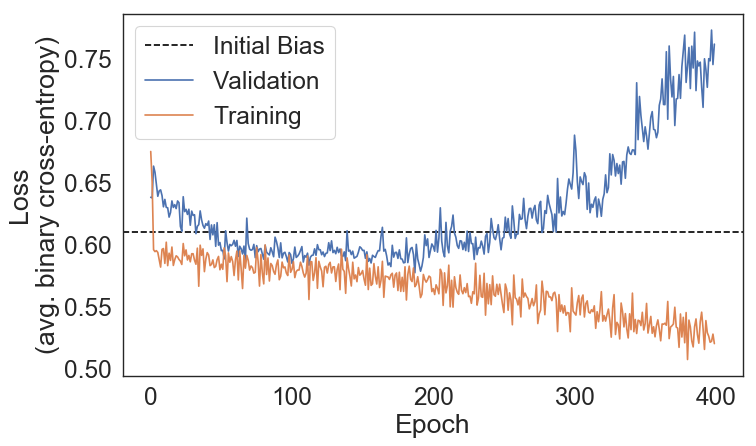

In [86]:
def plot_learning_curve(logged_history, with_convolution=False, plot_kwargs={}):
    
    with mpl.rc_context(rc={"figure.figsize": (10,6)}):

        loss = logged_history["loss"]
        val_loss = logged_history["val_loss"]
        
        if with_convolution:
            simple_conv = lambda x: np.convolve(x, np.ones(5)/5, mode="valid")
            
            loss = simple_conv(loss)
            val_loss = simple_conv(val_loss)
            

        plt.axhline(prior_loss, label="Initial Bias", 
                    linestyle="dashed", color="black",
                    **plot_kwargs,
                   )

        plt.plot(val_loss, label="Validation", 
                 **plot_kwargs,
                )
        plt.plot(loss, label="Training",
                 **plot_kwargs,
                )

        plt.xlabel("Epoch")
        plt.ylabel("Loss\n(avg. binary cross-entropy)")

        plt.legend()

plot_learning_curve(logged_history,)

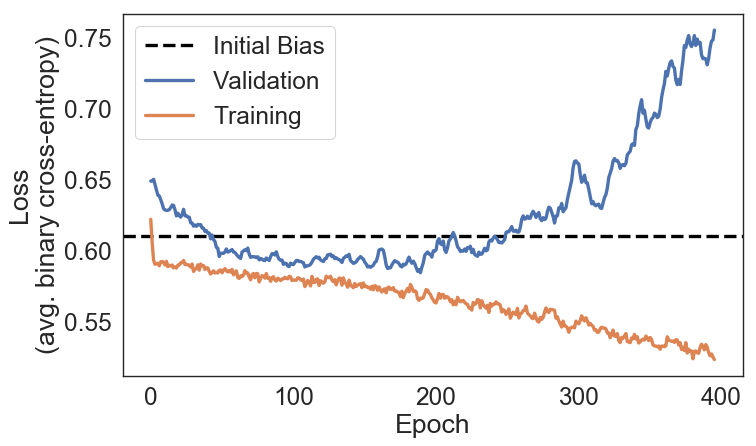

In [87]:
plot_learning_curve(logged_history, 
                    with_convolution=True, plot_kwargs=dict(linewidth=linewidth),
                   )

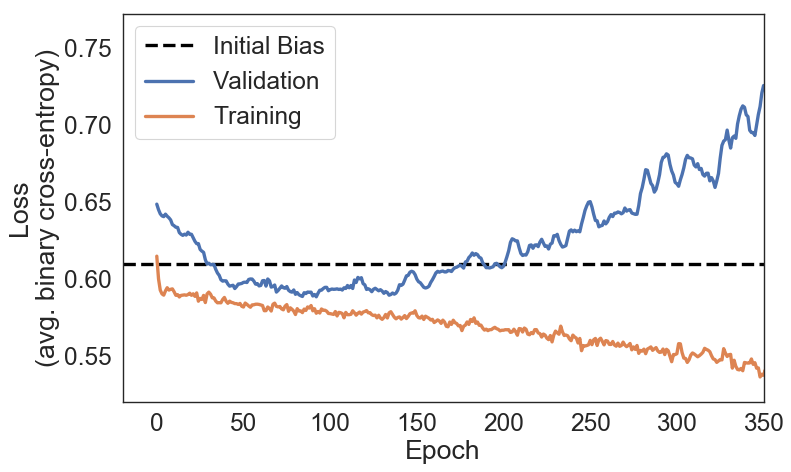

In [88]:
logged_history_for_thesis = pd.read_csv("training.thesis.log")
logged_history_for_thesis.head()

plot_learning_curve(logged_history_for_thesis, 
                    with_convolution=True, plot_kwargs=dict(linewidth=linewidth),
                   )

plt.xlim(right=350)

plot_filename = "plots_for_thesis/learning_curve-smoothed"
plt.tight_layout()
plt.savefig(plot_filename + ".pdf")
plt.savefig(plot_filename + ".png")



# 9) Look at validation results

## 9A) First save CNN-predicted probabilities
This also saves "predictions" for the *training* data, just to be complete

In [89]:
overwrite = False
use_cached_if_exists = True
class_probs_filename = "class_probs.csv"

if use_cached_if_exists and pathlib.Path(class_probs_filename).is_file():
    df_class_probs = pd.read_csv(class_probs_filename)
else:
    X_transformed = np.array([datagen.standardize(X_img)
                              for X_img in X])
    class_probs = model.predict_proba(X_transformed).flatten()
    
    df_class_probs = pd.DataFrame({
        "HSC_id": HSC_ids,
        "CNN_prob": class_probs,
        "testing": [HSC_id in HSC_ids[testing_set_indices] for HSC_id in HSC_ids],
        "target": Y,
    })

    if overwrite or (not pathlib.Path(class_probs_filename).is_file()):
        df_class_probs.to_csv(class_probs_filename, index=False)

df_class_probs.head()

,HSC_id,CNN_prob,testing,target
0,43158176442374224,0.433963,False,False
1,43158176442374373,0.232534,False,False
2,43158176442374445,0.429375,False,True
3,43158176442375078,0.412902,False,True
4,43158176442375086,0.197128,False,False


## 9b) Combined CNN probability with RF prob

In [90]:
def logit(p):
    return np.log(p/(1-p))

def expit(x):
    return (1 + np.exp(-x))**-1

def combine_probabilities(prob_a, prob_b, prior_prob_a, prior_prob_b, prior_prob_overall):
    logit_post_a = logit(prob_a)
    logit_post_b = logit(prob_b)
    logit_prior_a = logit(prior_prob_a)
    logit_prior_b = logit(prior_prob_b)
    
    logit_prior_overall = logit(prior_prob_overall)
    
    p_combined = expit(logit_prior_overall + logit_post_a + logit_post_b - logit_prior_a - logit_prior_b)
    return p_combined
    


In [91]:
hdf_file = pathlib.Path.cwd().parent / "catalog_only_classifier" / "results_cross-validated_all.hdf5"
df_catalog_only = pd.read_hdf(hdf_file)
df_catalog_only = df_catalog_only[["HSC_id", "RF_prob", "target"]]
df_catalog_only = df_catalog_only.set_index("HSC_id").reset_index()
df_catalog_only.head()

df_combined_probs = pd.DataFrame(dict(
    HSC_id = df_catalog_only.HSC_id,
    RF_prob = df_catalog_only.RF_prob,
    CNN_prob = [np.nan]*df_catalog_only.shape[0],
    target = df_catalog_only.target,
    testing = True,
    weight = 1,
    has_CNN = False,
))
df_combined_probs = df_combined_probs.set_index("HSC_id")

for _, row in df_class_probs.iterrows():
    df_combined_probs.loc[row.HSC_id, "CNN_prob"] = row.CNN_prob
    df_combined_probs.loc[row.HSC_id, "testing"] = row.testing
    df_combined_probs.loc[row.HSC_id, "weight"] = df_class_probs.testing.mean()**-1
    df_combined_probs.loc[row.HSC_id, "has_CNN"] = True
    
df_combined_probs["RF_prob_softened"] = (df_combined_probs.RF_prob * 1000 + 1) / (1000 + 2) 
RF_softened_prior = df_combined_probs.RF_prob_softened.mean()
CNN_prior = df_combined_probs[df_combined_probs.has_CNN & ~df_combined_probs.testing].target.mean()
df_combined_probs["combined_prob"] = df_combined_probs.apply(lambda row:
                                                             combine_probabilities(row.RF_prob_softened, 
                                                                                   row.CNN_prob,
                                                                                   RF_softened_prior, 
                                                                                   CNN_prior,
                                                                                   RF_softened_prior,
                                                                                  )
                                                             if row.has_CNN else row.RF_prob_softened,
                                                             axis="columns",
                                                            )
    
df_testing = df_combined_probs[df_combined_probs.testing]

df_combined_probs.head()

,RF_prob,CNN_prob,target,testing,weight,has_CNN,RF_prob_softened,combined_prob
HSC_id,,,,,,,,
43158176442354198,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354210,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354213,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354230,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354240,0.0,NaN,False,True,1.0,False,0.000998,0.000998


## 9c) Plots for just CNN probabilities

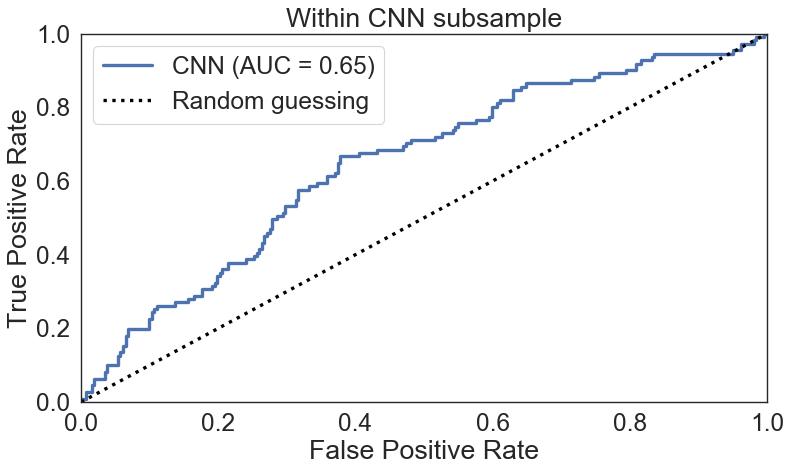

In [66]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    df_testing_tmp = df_testing[df_testing.has_CNN]
    fpr, tpr, _ = metrics.roc_curve(df_testing_tmp.target, df_testing_tmp.CNN_prob)
    roc_auc = roc_auc_score(df_testing_tmp.target, df_testing_tmp.CNN_prob)

    plt.plot(fpr, tpr, label="CNN (AUC = {:.2})".format(roc_auc), color=color_CNN, linewidth=linewidth)
    plt.plot([0,1], [0,1], linestyle="dotted", color="black", label="Random guessing",
             linewidth=linewidth,
            )

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("Within CNN subsample")

    plt.legend(loc="best")
    
    plt.tight_layout()
    plot_filename = "plots_for_thesis/ROC-CNN_sample"
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


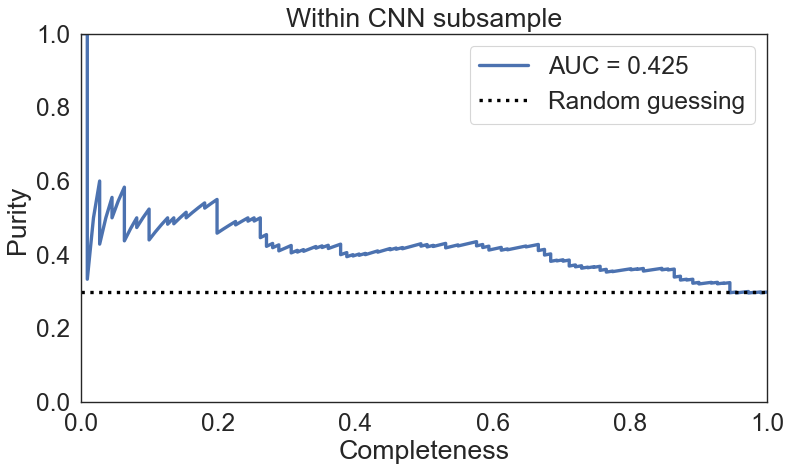

In [67]:
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    df_testing_tmp = df_testing[df_testing.has_CNN]
    precision, recall, _ = metrics.precision_recall_curve(df_testing_tmp.target, df_testing_tmp.CNN_prob)
    pr_auc = average_precision_score(df_testing_tmp.target, df_testing_tmp.CNN_prob)

    plt.plot(recall, precision, label="AUC = {:.3}".format(pr_auc), color=color_CNN, linewidth=linewidth)
    
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dotted", color="black", 
             label="Random guessing",
             linewidth=linewidth,
            )


    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Completeness")
    plt.ylabel("Purity ")

    plt.title("Within CNN subsample")

    plt.legend(loc="best")
    
    plt.tight_layout()
    plot_filename = "plots_for_thesis/purity_completeness-CNN_sample"
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


# Now run some metrics for CNN *+ RF*

First, I need to find a way to combine the two scores from the models.

For just creating _scores_ (e.g. for PR and ROC curves) I can do the following: 

 1) If the object didn't pass the RF cut, then leave it's score as the RF probability
 2) If the object did pass the RF cut, then use $\mathrm{score} = 1 + p_\mathrm{CNN}$. This is effectively what I'm doing in terms of my thresholded cut. 
 
But what about the actual combined probability?  I ideally want to get a binary cross-entropy, to see if this helped at all. Also, there's still some information that can be used from the RF

For now just try averaging **but see if we can come up with something better later**

In [68]:
df_combined_probs[df_combined_probs.has_CNN].head()

,RF_prob,CNN_prob,target,testing,weight,has_CNN,RF_prob_softened,combined_prob
HSC_id,,,,,,,,
43158176442374224,0.302,0.433963,False,False,5.002681,True,0.302395,0.467475
43158176442374373,0.113,0.232534,False,False,5.002681,True,0.113772,0.093172
43158176442374445,0.438,0.429375,True,False,5.002681,True,0.438124,0.607818
43158176442375078,0.574,0.412902,True,False,5.002681,True,0.573852,0.714417
43158176442375086,0.174,0.197128,False,False,5.002681,True,0.174651,0.120678


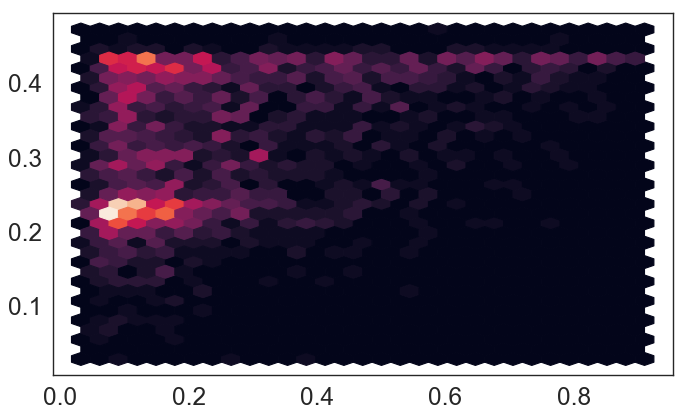

In [69]:
df_tmp = df_combined_probs[df_combined_probs.has_CNN]
plt.hexbin(df_tmp.RF_prob, df_tmp.CNN_prob, gridsize=30)


In [70]:
df_testing.head()

,RF_prob,CNN_prob,target,testing,weight,has_CNN,RF_prob_softened,combined_prob
HSC_id,,,,,,,,
43158176442354198,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354210,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354213,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354230,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354240,0.0,NaN,False,True,1.0,False,0.000998,0.000998


In [71]:
from scipy.special import expit
threshold_probs = expit(np.linspace(-9, 6, num=2000))
threshold_probs = np.array([-1e-6, *threshold_probs, 1+1e-6])

def get_purities(key, df_results=df_testing, threshold_probs=threshold_probs, weighted=True):
    
    purities = np.empty_like(threshold_probs)
    df_tmp = df_results[[key, "target", "weight"]].copy()
    if not weighted:
        df_tmp["weight"] = 1
    
    for i, threshold_prob in enumerate(threshold_probs):
        mask = df_tmp[key] > threshold_prob
        purities[i] = (df_tmp["target"][mask] * df_tmp["weight"][mask]).sum() / df_tmp["weight"][mask].sum()
    
    return purities

def get_completenesses(key, df_results=df_testing, threshold_probs=threshold_probs, weighted=True):
    
    completenesses = np.empty_like(threshold_probs)
    df_tmp = df_results[[key, "target", "weight"]]
    df_tmp = df_tmp[df_tmp.target].copy()
    if not weighted:
        df_tmp["weight"] = 1

    for i, threshold_prob in enumerate(threshold_probs):
        mask = df_tmp[key] > threshold_prob

        completenesses[i] = df_tmp[mask].weight.sum() / df_tmp.weight.sum()
    
    return completenesses


In [72]:
print("ROC AUC - RF (original): ", roc_auc_score(df_combined_probs.target, df_combined_probs.RF_prob_softened))
print("ROC AUC - RF (weighted): ", roc_auc_score(df_testing.target, df_testing.RF_prob_softened, sample_weight=df_testing.weight))


ROC AUC - RF (original):  0.9715697894047796
ROC AUC - RF (weighted):  0.9727745254070185


In [73]:
print("PR AUC - RF (original): ", sklearn.metrics.average_precision_score(df_combined_probs.target, df_combined_probs.RF_prob_softened))
print("PR AUC - RF (weighted): ", sklearn.metrics.average_precision_score(df_testing.target, df_testing.RF_prob_softened, sample_weight=df_testing.weight))


PR AUC - RF (original):  0.4717104271298889
PR AUC - RF (weighted):  0.4821918238086995


In [74]:
print("ROC AUC - combined (weighted): ", roc_auc_score(df_testing.target, df_testing.combined_prob, sample_weight=df_testing.weight))


ROC AUC - combined (weighted):  0.9727389828610948


In [75]:
print("PR AUC - RF (weighted):       ", sklearn.metrics.average_precision_score(df_testing.target, df_testing.RF_prob_softened, sample_weight=df_testing.weight))
print("PR AUC - combined (weighted): ", sklearn.metrics.average_precision_score(df_testing.target, df_testing.combined_prob, sample_weight=df_testing.weight))


PR AUC - RF (weighted):        0.4821918238086995
PR AUC - combined (weighted):  0.4815925383121601


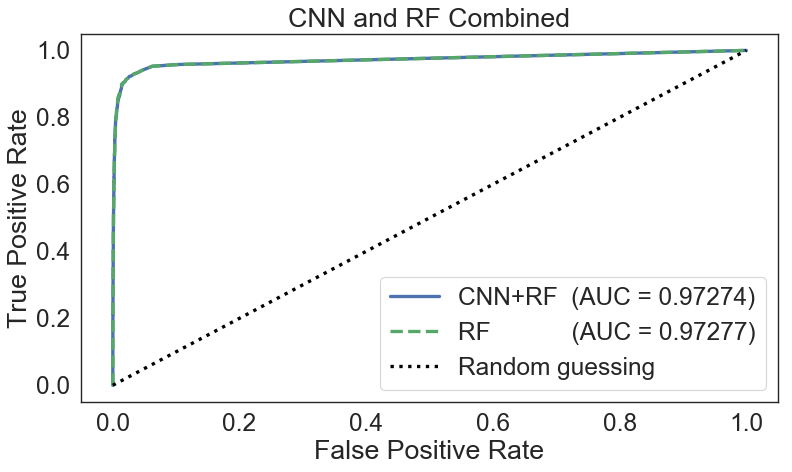

In [76]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": np.array((10,6))}):
    fpr, tpr, _ = metrics.roc_curve(df_testing.target, df_testing.combined_prob, sample_weight = df_testing.weight)
    roc_auc = roc_auc_score(df_testing.target, df_testing.combined_prob, sample_weight=df_testing.weight)

    plt.plot(fpr, tpr, label="CNN+RF  (AUC = {:.5})".format(roc_auc), color=color_CNN, linewidth=linewidth,
             linestyle=linestyle_CNN)
    
    fpr, tpr, _ = metrics.roc_curve(df_testing.target, df_testing.RF_prob_softened,
                                    sample_weight=df_testing.weight,
                                   )
    roc_auc_RF = roc_auc_score(df_testing.target, df_testing.RF_prob_softened,
                               sample_weight=df_testing.weight,
                              )
    plt.plot(fpr, tpr, label="RF            (AUC = {:.5})".format(roc_auc_RF), 
             color=color_RF, linewidth=linewidth, linestyle=linestyle_RF)
    
    
    plt.plot([0,1], [0,1], linestyle="dotted", color="black", label="Random guessing",
             linewidth=linewidth,
            )

#     plt.xlim(0,1)
#     plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("CNN and RF Combined")

    plt.legend(loc="best")
    
    plt.tight_layout()
    plot_filename = "plots_for_thesis/ROC-CNN_and_RF"
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


/Users/egentry/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


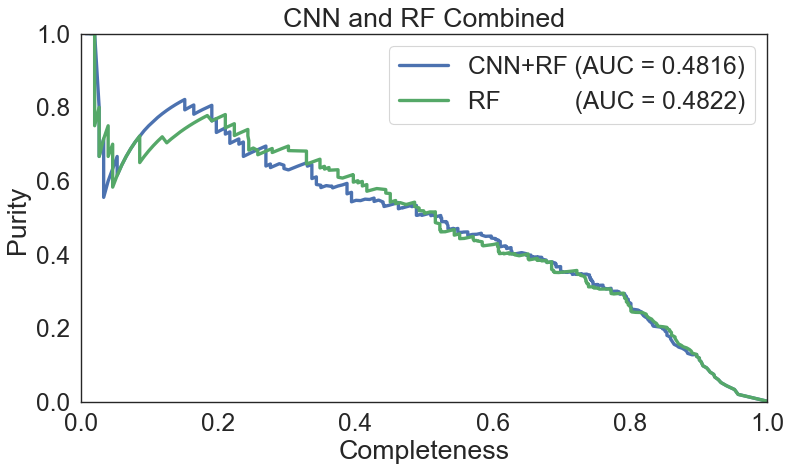

In [77]:
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):    
    pr_auc = average_precision_score(df_testing.target, df_testing.combined_prob, sample_weight=df_testing.weight)
    recall = get_completenesses("combined_prob")
    precision = get_purities("combined_prob")
    
    plt.plot(recall, precision, label="CNN+RF (AUC = {:.4})".format(pr_auc), 
             color=color_CNN, linewidth=linewidth)

    pr_auc_RF = average_precision_score(df_testing.target, df_testing.RF_prob_softened,
                                        sample_weight=df_testing.weight)
    recall_RF = get_completenesses("RF_prob_softened")
    precision_RF = get_purities("RF_prob_softened")

    plt.plot(recall_RF, precision_RF, label="RF           (AUC = {:.4})".format(pr_auc_RF), 
             color=color_RF, linewidth=linewidth)
    
    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Completeness")
    plt.ylabel("Purity ")

    plt.title("CNN and RF Combined")

    plt.legend(loc="best")
    
    plt.tight_layout()
    plot_filename = "plots_for_thesis/purity_completeness-CNN_and_RF"
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


In [78]:
df_testing.head()

,RF_prob,CNN_prob,target,testing,weight,has_CNN,RF_prob_softened,combined_prob
HSC_id,,,,,,,,
43158176442354198,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354210,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354213,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354230,0.0,NaN,False,True,1.0,False,0.000998,0.000998
43158176442354240,0.0,NaN,False,True,1.0,False,0.000998,0.000998


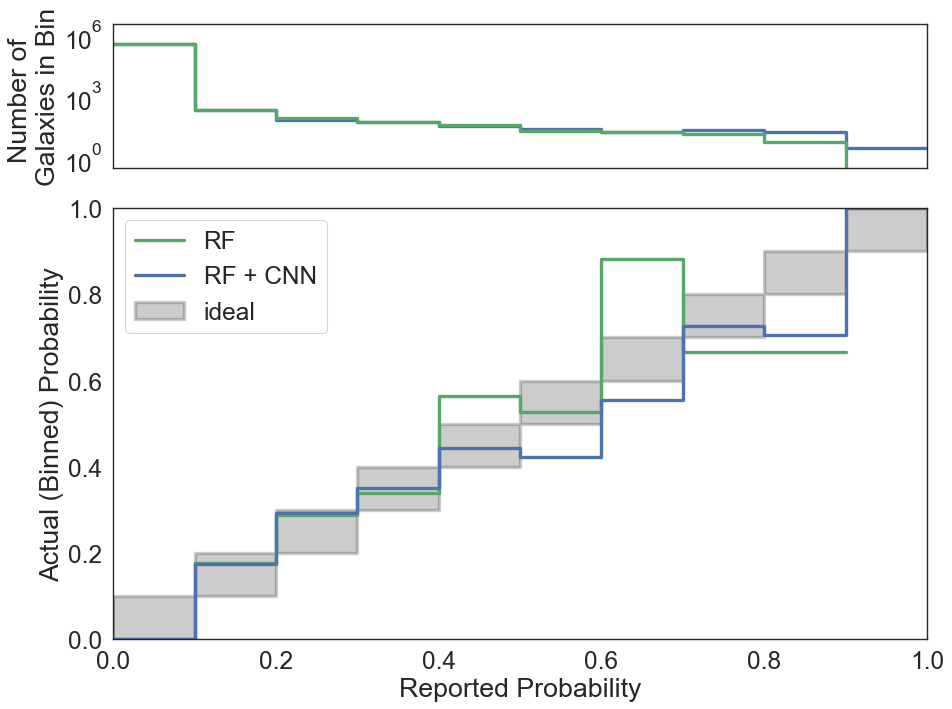

In [79]:
with plt.rc_context({"figure.figsize":1.5*np.array((8,6))}):
    theoretical_probs=np.linspace(0,1,num=11)
    empirical_probs_RF = np.empty(theoretical_probs.size-1)
    num_in_bin_RF = np.empty_like(empirical_probs_RF)

    empirical_probs_combined = np.empty(theoretical_probs.size-1)
    num_in_bin_combined = np.empty_like(empirical_probs_combined)

    for i in range(theoretical_probs.size-1):
        prob_lim_low  = theoretical_probs[i]
        prob_lim_high = theoretical_probs[i+1]

        mask_RF = (df_testing["RF_prob_softened"] >= prob_lim_low) & (df_testing["RF_prob_softened"] < prob_lim_high)
        empirical_probs_RF[i] = df_testing["target"][mask_RF].mean()
        num_in_bin_RF[i] = df_testing["target"][mask_RF].size

        mask_combined = (df_testing["combined_prob"] >= prob_lim_low) & (df_testing["combined_prob"] < prob_lim_high)
        empirical_probs_combined[i] = df_testing["target"][mask_combined].mean()
        num_in_bin_combined[i] = df_testing["target"][mask_combined].size

    f, (ax1, ax2) = plt.subplots(2, sharex=True, 
                                 gridspec_kw = {'height_ratios':[1, 3]},
                                )

    ax1.plot(theoretical_probs, [num_in_bin_combined[0], *num_in_bin_combined],
             drawstyle="steps", color=color_CNN,
             linewidth=linewidth,
            )
    
    ax1.plot(theoretical_probs, [num_in_bin_RF[0], *num_in_bin_RF],
             drawstyle="steps", color=color_RF,
             linewidth=linewidth,
            )

    ax1.set_yscale("log")
    ax1.set_ylim(bottom=10**-.5, top=10**6.5)
    ax1.yaxis.set_ticks([1e0, 1e3, 1e6])
    ax1.set_ylabel("Number of \nGalaxies in Bin")

    ax2.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
             linestyle="steps", color=color_RF, label="RF",
             linewidth=linewidth,
            )
    
    ax2.step(theoretical_probs, [empirical_probs_combined[0], *empirical_probs_combined], 
             linestyle="steps", color=color_CNN, label="RF + CNN",
             linewidth=linewidth,
            )

    # ax2.plot(theoretical_probs, theoretical_probs-.05, 
    #          drawstyle="steps", color="black", label="ideal", linestyle="dotted")

    ax2.fill_between(theoretical_probs, theoretical_probs-theoretical_probs[1], theoretical_probs, 
                     step="pre", color="black", label="ideal", alpha=.2,
                     linewidth=linewidth,
                    )

    plt.xlabel("Reported Probability")
    plt.ylabel("Actual (Binned) Probability")

    plt.legend(loc="upper left")

    plt.xlim(0,1)
    plt.ylim(0,1)


    plt.tight_layout()


    filename = "plots_for_thesis/probability-calibration-RF_and_CNN"
    plt.tight_layout()
    plt.savefig(filename + ".pdf")
    plt.savefig(filename + ".png")


Now get the **combined cross entropy**

In [80]:
sklearn.metrics.log_loss(df_testing.target,
                         df_testing.combined_prob,
                         sample_weight=df_testing.weight,
                        )


0.007040964268274968

In [81]:
sklearn.metrics.log_loss(df_testing.target,
                         df_testing.RF_prob_softened,
                         sample_weight=df_testing.weight,
                        )


0.007018665013401135

In [82]:
sklearn.metrics.log_loss(df_testing[df_testing.has_CNN].target,
                         df_testing[df_testing.has_CNN].combined_prob,
                         sample_weight=df_testing[df_testing.has_CNN].weight,
                        )


0.521149599081223

In [83]:
sklearn.metrics.log_loss(df_testing[df_testing.has_CNN].target,
                         df_testing[df_testing.has_CNN].RF_prob,
                         sample_weight=df_testing[df_testing.has_CNN].weight,
                        )


0.5173064221591772

# Misc analysis

## Apply a threshold
For now, just use a threshold using the prior class probability (estimated from the training set)


In [ ]:
predicted_classes = class_probs > (Y[training_set_indices].mean())
predicted_classes.mean()

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y[testing_set_indices], predicted_classes)
confusion_matrix

In [ ]:
print("number of dwarfs (true)     : ", Y[testing_set_indices].sum())
print("number of dwarfs (predicted): ", predicted_classes.sum())

In [ ]:
import itertools
# adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(confusion_matrix_normalized, interpolation='nearest',cmap="gray_r")
# plt.title(title)
plt.colorbar()
tick_marks = np.arange(2)
classes = [False, True]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = 1 / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], fmt),
             fontdict={"size":20},
             horizontalalignment="center",
             color="white" if confusion_matrix_normalized[i, j] > thresh else "black")

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
print("  i - Y_true[i] - Y_pred[i] -  error?")
print("-------------------------------------")
for i in range(predicted_classes.size):
    print("{:>3} -    {:>1d}      -    {:d}      -   {:>2d}".format(i, 
                                                    Y[testing_set_indices][i], 
                                                    predicted_classes[i],
                                                    (Y[testing_set_indices][i] != predicted_classes[i]), 
                                                   ))

# Analyze Errors

In [ ]:
HSC_ids

In [ ]:
df.loc[HSC_ids[testing_set_indices]].head()

In [ ]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, 
                               "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [ ]:
HSC_filename = os.path.join(dwarfz.data_dir_default, 
                            "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [ ]:
matches_filename = os.path.join(dwarfz.data_dir_default, 
                                "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [ ]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med
combined["active"]   = COSMOS.df.loc[combined.index].classification

combined = combined.set_index("catalog_2_ids")

combined.head()

In [ ]:
df_features_testing = combined.loc[HSC_ids[testing_set_indices]]

In [ ]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
# mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
#            C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Number of objects",
            )

plt.suptitle("All Objects")


In [ ]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
# mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
           C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Average Predicted\nProb. within bin",
            )


plt.suptitle("All Objects")


^^ Huh, that's a pretty uniform looking spread. It doesn't really seem like it's trending in an useful direction (either near the desired boundaries or as you go further away).

In [ ]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
           C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Average Predicted\nProb. within bin",
            )

plt.suptitle("False Positives")
